# Requires the following:
* Census API Key: Add in `.env` file
* County FP labels: [Link](https://www2.census.gov/geo/docs/reference/codes2020/cou/st47_tn_cou2020.txt)
* Census Variable Maps: [Link](https://api.census.gov/data/2022/acs/acs5/variables.json)
* Census Block/Tract Level shapefiles: [Link](https://www.census.gov/cgi-bin/geo/shapefiles/index.php)
<!-- * Building Data: [Link](https://github.com/microsoft/USBuildingFootprints?tab=readme-ov-file) -->

In [1]:
import logging
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
from src.civicsim.common.utils import get_census_data

In [2]:
from os import getenv
from dotenv import load_dotenv
load_dotenv("./.env")

True

In [3]:
pd.set_option('display.max_columns', 100)
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [4]:
CENSUS_API_KEY = getenv("CENSUS_API_KEY")

In [12]:
## Potential groups for analysis:
acs_groups = {
              "age_sex_educational_attainment": {"group":"B15001", "level":"tract"},
              "age_sex": {"group":"B01001", "level":"block"},
              "estimated_yearly_income": {"group":"B25121", "level":"tract"}
              }

In [6]:
# Counties at/around Smyrna (rutherford)
counties = ["Davidson", "Wilson", "DeKalb", "Warren", "Rutherford", "Williamson", "Coffee", "Bedford", "Marshall", "Maury", "Cannon"]
counties = [f"{c} County" for c in counties]
print(len(counties))

# 11 counties around BOC
# https://www2.census.gov/geo/docs/reference/codes2020/cou/st47_tn_cou2020.txt
county_maps = pd.read_csv("./data/st47_tn_cou2020.txt", delimiter="|")
county_maps = county_maps[county_maps['COUNTYNAME'].isin(counties)]
county_maps["COUNTYFP"] = county_maps["COUNTYFP"].astype('str')
county_maps["COUNTYFP"] = county_maps["COUNTYFP"].str.zfill(3)
display(county_maps)
county_maps.shape

11


,STATE,STATEFP,COUNTYFP,COUNTYNS,COUNTYNAME,CLASSFP,FUNCSTAT
1,TN,47,003,1639723,Bedford County,H1,A
7,TN,47,015,1648572,Cannon County,H1,A
15,TN,47,031,1639735,Coffee County,H1,A
18,TN,47,037,1639737,Davidson County,H6,C
20,TN,47,041,1639738,DeKalb County,H1,A
58,TN,47,117,1639771,Marshall County,H1,A
59,TN,47,119,1639772,Maury County,H1,A
74,TN,47,149,1639787,Rutherford County,H1,A
88,TN,47,177,1639796,Warren County,H1,A
93,TN,47,187,1639801,Williamson County,H1,A


(11, 7)

In [7]:
COUNTY_FPS_MAP = county_maps[["COUNTYNAME", "COUNTYFP"]].set_index("COUNTYNAME").to_dict()['COUNTYFP']
COUNTYFPS = [COUNTY_FPS_MAP[k] for k in COUNTY_FPS_MAP.keys()]

In [8]:
STATEFP = '47' # TN

ACS5 = "https://api.census.gov/data/2022/acs/acs5"

In [13]:
desired_groups = ["age_sex", "age_sex_educational_attainment", "estimated_yearly_income"]
desired_var_group = [acs_groups[k]['group'] for k in desired_groups]
if not isinstance(desired_var_group, list):
    desired_var_group = [desired_var_group]
desired_var_group

['B01001', 'B15001', 'B25121']

In [14]:
census_vars_path = "./data/variables.json"
with open(census_vars_path) as f:
    census_vars = json.load(f)
census_vars = census_vars['variables']
census_vars_df = pd.DataFrame.from_dict(census_vars, orient='index')

census_vars_df = census_vars_df[census_vars_df['group'].isin(desired_var_group)]
census_vars_df = census_vars_df.transpose()

# # Rename texts
# # Replace '!!' with '_' in the data as well, if needed
# census_vars_df = census_vars_df.replace('Estimate!!Total:!!Male:!!', 'Estimate_Total_Male_', regex=True)
# census_vars_df = census_vars_df.replace('Estimate!!Total:!!Female:!!', 'Estimate_Total_Female_', regex=True)
# census_vars_df = census_vars_df.replace(' to ', '_to_', regex=True)
# census_vars_df = census_vars_df.replace(' and ', '_and_', regex=True)
# census_vars_df = census_vars_df.replace(' years', '_years', regex=True)

# Final name mapping
rename_dict = census_vars_df.loc['label'].to_dict()
rename_dict

{'B25121_039E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$20,000 to $34,999:!!Value $60,000 to $69,999',
 'B25121_038E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$20,000 to $34,999:!!Value $50,000 to $59,999',
 'B25121_033E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$20,000 to $34,999:!!Value less than $10,000',
 'B25121_032E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$20,000 to $34,999:',
 'B25121_031E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$10,000 to $19,999:!!Value $500,000 or more',
 'B25121_030E': 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$10,000 to $19,999:!!Value $250,000 to $499,999',
 'B25121_037E': 'Estimate!!Total:!!Household income the past 12 mon

# Get dataset from available API
* [Available APIs](https://www.census.gov/data/developers/data-sets.html)
* American Community Survey 5-Year Data (2009-2022)
    * Data available down to the block-group level. Covers a range of topics about social, economic, demographic, and housing characteristics of the U.S. population. 
> Some tables are only available at certain levels (tract, block or block group). You will need to process them separately or combine them to the granularity you need.

In [15]:
# Loop through all included counties

census_data_df_arr = []
for table in desired_groups:
    county_var_group_arr = []
    for COUNTYFP in COUNTYFPS:
        logger.debug(f"Getting data for county {COUNTYFP}")
        var_group = acs_groups[table]["group"]
        var_level = acs_groups[table]["level"]
        census_data_df = get_census_data(CENSUS_API_KEY, ACS5, var_group, "47", f"{COUNTYFP}", "*", level=var_level)
        # Uncomment line below to get the string equivalent of the column label.
        # census_data_df.rename(columns=rename_dict, inplace=True)

        # Drop columns for margin of error, annotation of estimate, annotation of margin of error and margin of error
        # Select columns that end with 'M', 'EA', or 'MA'
        cols_to_drop = census_data_df.filter(regex='(M|EA|MA)$').columns

        # Drop the selected columns from the DataFrame
        census_data_df.drop(cols_to_drop, axis=1, inplace=True)
        # Convert columns containing "Estimate" in their names to float
        estimate_cols = [col for col in census_data_df.columns if 'Estimate' in col]
        census_data_df[estimate_cols] = census_data_df[estimate_cols].astype(float)
        
        county_var_group_arr.append(census_data_df)
    county_var_group_df = pd.concat(county_var_group_arr)
    census_data_df_arr.append(county_var_group_df)

# census_data_df = pd.concat(census_data_df_arr)
# census_data_df['GEOID'] = census_data_df['state'] + census_data_df['county'] + census_data_df['tract'] + census_data_df['block group']
# census_data_df.shape

https://api.census.gov/data/2022/acs/acs5
{'get': 'NAME,group(B01001)', 'for': 'block group:*', 'in': 'state:47 county:003', 'key': 'd5bd87e9fe4db19d2c5c5150ec106748a006a2dd'}
https://api.census.gov/data/2022/acs/acs5?get=NAME%2Cgroup%28B01001%29&for=block+group%3A%2A&in=state%3A47+county%3A003&key=d5bd87e9fe4db19d2c5c5150ec106748a006a2dd
https://api.census.gov/data/2022/acs/acs5
{'get': 'NAME,group(B01001)', 'for': 'block group:*', 'in': 'state:47 county:015', 'key': 'd5bd87e9fe4db19d2c5c5150ec106748a006a2dd'}
https://api.census.gov/data/2022/acs/acs5?get=NAME%2Cgroup%28B01001%29&for=block+group%3A%2A&in=state%3A47+county%3A015&key=d5bd87e9fe4db19d2c5c5150ec106748a006a2dd
https://api.census.gov/data/2022/acs/acs5
{'get': 'NAME,group(B01001)', 'for': 'block group:*', 'in': 'state:47 county:031', 'key': 'd5bd87e9fe4db19d2c5c5150ec106748a006a2dd'}
https://api.census.gov/data/2022/acs/acs5?get=NAME%2Cgroup%28B01001%29&for=block+group%3A%2A&in=state%3A47+county%3A031&key=d5bd87e9fe4db19d2c

In [16]:
for x in census_data_df_arr:
    print(x.shape)

(1033, 56)
(385, 89)
(385, 112)


In [21]:
desired_groups

['age_sex', 'age_sex_educational_attainment', 'estimated_yearly_income']

In [22]:
block_age_sex = census_data_df_arr[0]
tract_age_sex_educational_attainment = census_data_df_arr[1]
tract_estimated_yearly_income= census_data_df_arr[2]

display(block_age_sex.head(1))
display(tract_age_sex_educational_attainment.head(1))
display(tract_estimated_yearly_income.head(1))

,NAME,B01001_001E,B01001_002E,B01001_003E,B01001_004E,B01001_005E,B01001_006E,B01001_007E,B01001_008E,B01001_009E,B01001_010E,B01001_011E,B01001_012E,B01001_013E,B01001_014E,B01001_015E,B01001_016E,B01001_017E,B01001_018E,B01001_019E,B01001_020E,B01001_021E,B01001_022E,B01001_023E,B01001_024E,B01001_025E,B01001_026E,B01001_027E,B01001_028E,B01001_029E,B01001_030E,B01001_031E,B01001_032E,B01001_033E,B01001_034E,B01001_035E,B01001_036E,B01001_037E,B01001_038E,B01001_039E,B01001_040E,B01001_041E,B01001_042E,B01001_043E,B01001_044E,B01001_045E,B01001_046E,B01001_047E,B01001_048E,B01001_049E,GEO_ID,NAME,state,county,tract,block group
0,Block Group 1; Census Tract 9501; Bedford Coun...,1796,887,28,59,127,4,21,21,9,38,13,70,89,46,36,93,16,19,61,17,3,51,47,8,11,909,95,80,38,7,7,13,0,34,64,45,40,19,74,91,53,28,24,48,22,36,85,2,4,1500000US470039501001,Block Group 1; Census Tract 9501; Bedford Coun...,47,003,950100,1


,NAME,B15001_001E,B15001_002E,B15001_003E,B15001_004E,B15001_005E,B15001_006E,B15001_007E,B15001_008E,B15001_009E,B15001_010E,B15001_011E,B15001_012E,B15001_013E,B15001_014E,B15001_015E,B15001_016E,B15001_017E,B15001_018E,B15001_019E,B15001_020E,B15001_021E,B15001_022E,B15001_023E,B15001_024E,B15001_025E,B15001_026E,B15001_027E,B15001_028E,B15001_029E,B15001_030E,B15001_031E,B15001_032E,B15001_033E,B15001_034E,B15001_035E,B15001_036E,B15001_037E,B15001_038E,B15001_039E,B15001_040E,B15001_041E,B15001_042E,B15001_043E,B15001_044E,B15001_045E,B15001_046E,B15001_047E,B15001_048E,B15001_049E,B15001_050E,B15001_051E,B15001_052E,B15001_053E,B15001_054E,B15001_055E,B15001_056E,B15001_057E,B15001_058E,B15001_059E,B15001_060E,B15001_061E,B15001_062E,B15001_063E,B15001_064E,B15001_065E,B15001_066E,B15001_067E,B15001_068E,B15001_069E,B15001_070E,B15001_071E,B15001_072E,B15001_073E,B15001_074E,B15001_075E,B15001_076E,B15001_077E,B15001_078E,B15001_079E,B15001_080E,B15001_081E,B15001_082E,B15001_083E,GEO_ID,NAME,state,county,tract
0,Census Tract 9501; Bedford County; Tennessee,3492,1847,300,0,57,69,122,32,20,0,391,2,7,75,242,21,36,8,354,0,27,49,82,0,64,132,503,30,24,163,146,47,62,31,299,0,19,93,117,8,29,33,1645,103,0,11,46,32,14,0,0,333,0,0,43,200,27,63,0,178,0,10,0,60,16,39,53,650,34,48,248,119,89,83,29,381,0,6,108,148,21,81,17,1400000US47003950100,Census Tract 9501; Bedford County; Tennessee,47,003,950100


,NAME,B25121_001E,B25121_002E,B25121_003E,B25121_004E,B25121_005E,B25121_006E,B25121_007E,B25121_008E,B25121_009E,B25121_010E,B25121_011E,B25121_012E,B25121_013E,B25121_014E,B25121_015E,B25121_016E,B25121_017E,B25121_018E,B25121_019E,B25121_020E,B25121_021E,B25121_022E,B25121_023E,B25121_024E,B25121_025E,B25121_026E,B25121_027E,B25121_028E,B25121_029E,B25121_030E,B25121_031E,B25121_032E,B25121_033E,B25121_034E,B25121_035E,B25121_036E,B25121_037E,B25121_038E,B25121_039E,B25121_040E,B25121_041E,B25121_042E,B25121_043E,B25121_044E,B25121_045E,B25121_046E,B25121_047E,B25121_048E,B25121_049E,...,B25121_062E,B25121_063E,B25121_064E,B25121_065E,B25121_066E,B25121_067E,B25121_068E,B25121_069E,B25121_070E,B25121_071E,B25121_072E,B25121_073E,B25121_074E,B25121_075E,B25121_076E,B25121_077E,B25121_078E,B25121_079E,B25121_080E,B25121_081E,B25121_082E,B25121_083E,B25121_084E,B25121_085E,B25121_086E,B25121_087E,B25121_088E,B25121_089E,B25121_090E,B25121_091E,B25121_092E,B25121_093E,B25121_094E,B25121_095E,B25121_096E,B25121_097E,B25121_098E,B25121_099E,B25121_100E,B25121_101E,B25121_102E,B25121_103E,B25121_104E,B25121_105E,B25121_106E,GEO_ID,NAME,state,county,tract
0,Census Tract 9501; Bedford County; Tennessee,1505,73,0,0,0,17,0,0,0,0,0,0,27,23,6,0,50,0,0,0,0,0,0,0,0,0,2,19,0,9,20,109,0,0,0,0,0,0,2,10,0,0,26,14,26,31,127,0,0,...,402,0,0,0,5,0,0,11,0,10,11,28,187,79,71,289,0,0,0,0,0,0,0,24,28,0,51,74,85,27,455,0,0,0,0,0,0,0,23,0,16,6,108,213,89,1400000US47003950100,Census Tract 9501; Bedford County; Tennessee,47,003,950100


> Assuming you only want yearly_income

In [50]:
census_data_df = tract_estimated_yearly_income
census_data_df['TRACTGEOID'] = census_data_df['state'] + census_data_df['county'] + census_data_df['tract']
if 'block group' in census_data_df.columns:
    census_data_df['GEOID'] = census_data_df['state'] + census_data_df['county'] + census_data_df['tract'] + census_data_df['block group']


# Gather for all county and merge
* For plotting and geo-matching

In [54]:
census_blocks_df = gpd.read_file("./data/censusblocks")
print(census_blocks_df.crs)

EPSG:4269


In [56]:
census_blocks_df = census_blocks_df[(census_blocks_df['COUNTYFP'].isin(COUNTYFPS)) & (census_blocks_df['STATEFP'] == STATEFP)]
census_blocks_df['TRACTGEOID'] = census_blocks_df['STATEFP'] + census_blocks_df['COUNTYFP'] + census_blocks_df['TRACTCE']
census_blocks_df.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,AFFGEOID,GEOID,NAME,NAMELSAD,LSAD,ALAND,AWATER,geometry,TRACTGEOID
1471,47,037,011400,1,1500000US470370114001,470370114001,1,Block Group 1,BG,860057,0,"POLYGON ((-86.73275 36.20171, -86.73219 36.204...",47037011400
1481,47,189,030600,1,1500000US471890306001,471890306001,1,Block Group 1,BG,1290545,0,"POLYGON ((-86.31514 36.21439, -86.31531 36.216...",47189030600
1483,47,119,010204,2,1500000US471190102042,471190102042,2,Block Group 2,BG,2156087,0,"POLYGON ((-86.90705 35.75039, -86.88806 35.743...",47119010204
1484,47,003,950401,2,1500000US470039504012,470039504012,2,Block Group 2,BG,3482593,0,"POLYGON ((-86.46831 35.46770, -86.46613 35.475...",47003950401
1488,47,037,019105,5,1500000US470370191055,470370191055,5,Block Group 5,BG,387917,0,"POLYGON ((-86.73941 36.05389, -86.73662 36.053...",47037019105


<Axes: >

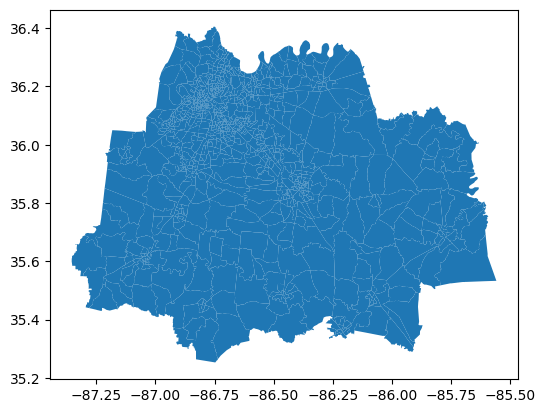

In [25]:
census_blocks_df.plot()

In [57]:
# If block level
# census_data_df = census_data_df.merge(census_blocks_df[["GEOID", "geometry"]], on="GEOID")
# census_data_df = gpd.GeoDataFrame(census_data_df, geometry="geometry")

#Else If tract level
census_data_df = census_data_df.merge(census_blocks_df[["TRACTGEOID", "geometry"]], on="TRACTGEOID")
census_data_df = gpd.GeoDataFrame(census_data_df, geometry="geometry")

In [74]:
# Sample column you want to plot
column = 'B25121_099E'

In [75]:
census_data_df[column] = census_data_df[column].astype('float')

In [76]:
# Sanity check
census_data_df.sum(numeric_only=True)

B25121_001E    1294163.0
B25121_099E        613.0
dtype: float64

In [77]:
# # Saving the data:
# census_data_df = census_data_df.drop(columns="NAME")
# census_data_df.to_file("./data/processed_block_age_sex.geojson")

In [78]:
# # Load the data
# census_data_df = gpd.read_file("./data/processed_block_age_sex.geojson")

In [79]:
# pre_filter = census_data_df.groupby("county").agg({"C15002E_005E":"sum"}).reset_index()

Text(0.5, 1.0, 'Estimate!!Total:!!Household income the past 12 months (in 2022 inflation-adjusted dollars) --!!$100,000 or more:!!Value $60,000 to $69,999')

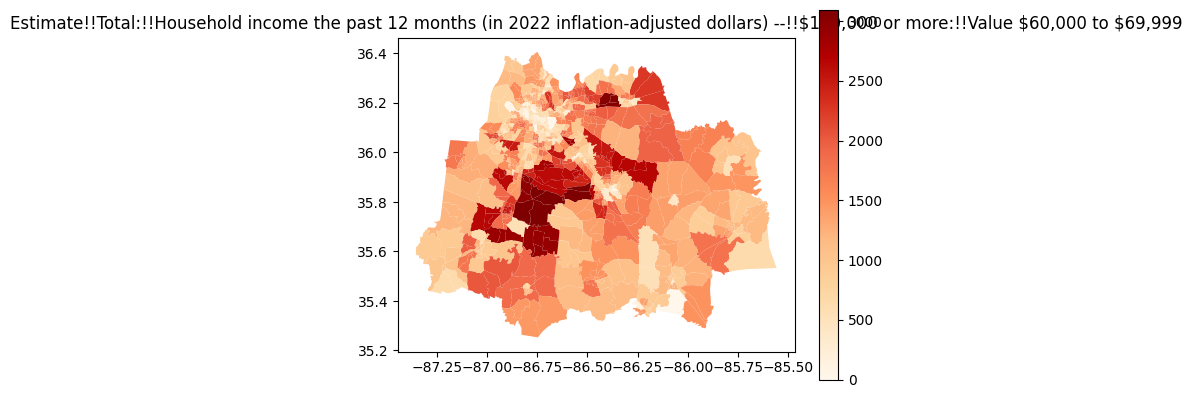

In [80]:
# Plotting heatmap for a data
# census_data_df.plot()
title = rename_dict[column]
ax = census_data_df.plot(column='B25121_001E', cmap='OrRd', legend=True)
ax.set_title(f"{title}")